# Praelexis technical assessment

- build a simple model of the data using the pymc package
- data source: https://www.kaggle.com/crowdflower/twitter-airline-sentiment

In [124]:
# Import libraries

# for data exploration
import numpy as np
import pandas as pd
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
from PIL import Image
import seaborn as sns
import plotly.express as px

# for processing data
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

# for modelling
import pymc as mp


# Exploring the data

Data preparation

In [3]:
# Read in data

df = pd.read_csv('.\data\Tweets.csv')

df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [4]:
print(df.dtypes, df.shape) # check data types and dimension of data

tweet_id                          int64
airline_sentiment                object
airline_sentiment_confidence    float64
negativereason                   object
negativereason_confidence       float64
airline                          object
airline_sentiment_gold           object
name                             object
negativereason_gold              object
retweet_count                     int64
text                             object
tweet_coord                      object
tweet_created                    object
tweet_location                   object
user_timezone                    object
dtype: object (14640, 15)


In [132]:
# Convert data type of tweet_created to datetime
df['tweet_created'] = pd.to_datetime(df['tweet_created'])

df.dtypes

tweet_id                                            int64
airline_sentiment                                  object
airline_sentiment_confidence                      float64
negativereason                                     object
negativereason_confidence                         float64
airline                                            object
airline_sentiment_gold                             object
name                                               object
negativereason_gold                                object
retweet_count                                       int32
text                                               object
tweet_coord                                        object
tweet_created                   datetime64[ns, UTC-08:00]
tweet_location                                     object
user_timezone                                      object
sentiment                                           int64
length                                              int64
text_processed

In [6]:
# Label encoding of airline sentiment

# create column called sentiment
"""
    Column sentiment:
    0 if neutral,
    1 if positive,
    2 if negative
"""

df['sentiment'] = 0
df.loc[df['airline_sentiment'] == 'positive', 'sentiment']=1
df.loc[df['airline_sentiment'] == 'negative', 'sentiment']=2

In [109]:
df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone,sentiment,length,text_processed,hour
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52-08:00,NaN,Eastern Time (US & Canada),0,4,"[virginamerica, dhepburn, said]",1970-01-01 00:00:00.000000011
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59-08:00,NaN,Pacific Time (US & Canada),1,9,"[virginamerica, plus, added, commercial, exper...",1970-01-01 00:00:00.000000011
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48-08:00,Lets Play,Central Time (US & Canada),0,12,"[virginamerica, today, must, mean, need, take,...",1970-01-01 00:00:00.000000011
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36-08:00,NaN,Pacific Time (US & Canada),2,17,"[virginamerica, really, aggressive, blast, obn...",1970-01-01 00:00:00.000000011
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45-08:00,NaN,Pacific Time (US & Canada),2,10,"[virginamerica, really, big, bad, thing]",1970-01-01 00:00:00.000000011


In [8]:
# Create separate dataframes for each sentiment

positive_df = df[df['airline_sentiment'] == 'positive']
neutral_df = df[df['airline_sentiment'] == 'neutral']
negative_df = df[df['airline_sentiment'] == 'negative']

Data visualisation

In [9]:
# Define a function to create a word cloud for text data categorised by sentiment

def wordcloud(data, variable, title):
    # Create an array from the image chosen as a mask
    usa_mask = np.array(Image.open(r'.\usa.jpg'))

    # Combine all the tweets into a single string for the specific dummy variable
    all_tweets = ' '.join(data[variable].astype(str))

    # Define stopwords and generate the word cloud
    stopwords = set(STOPWORDS)       # common words to exclude
    wordcloud = WordCloud(width=800, height=800,
                          background_color= "white",
                          stopwords=stopwords,
                          mask=usa_mask,
                          contour_color="#90EE90",
                          contour_width=1,
                          min_font_size=10).generate(all_tweets)

    # Plot the WordCloud image
    plt.figure(figsize=(8, 8), facecolor=None)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.tight_layout(pad=0)
    plt.title(f"Word cloud for {title}", fontsize=15)
    plt.show()


image source: https://suncatcherstudio.com/image-editor/

Call function

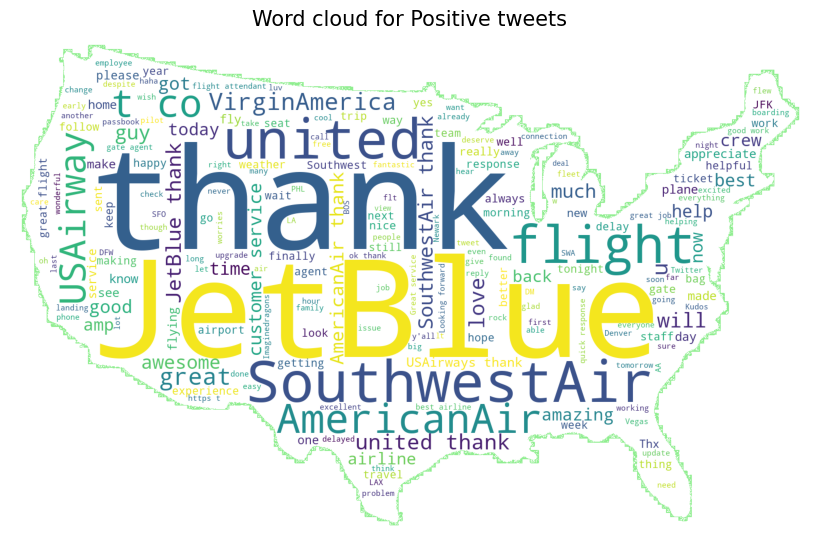

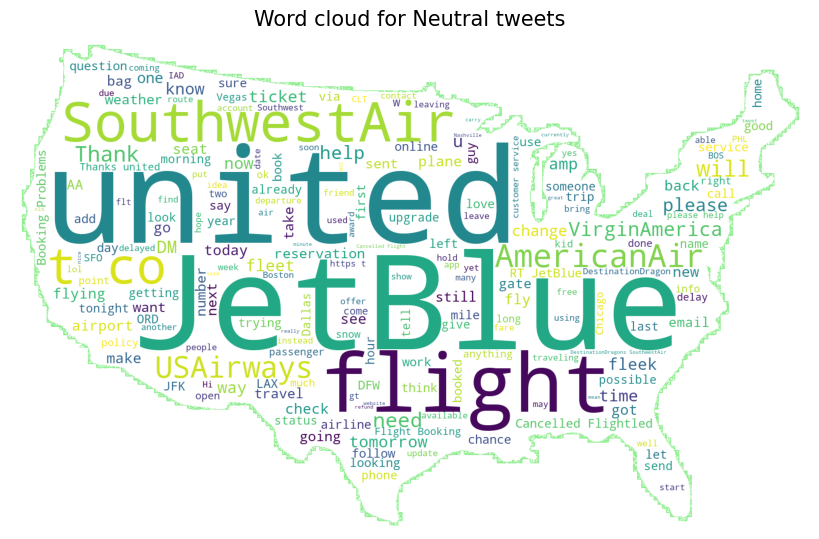

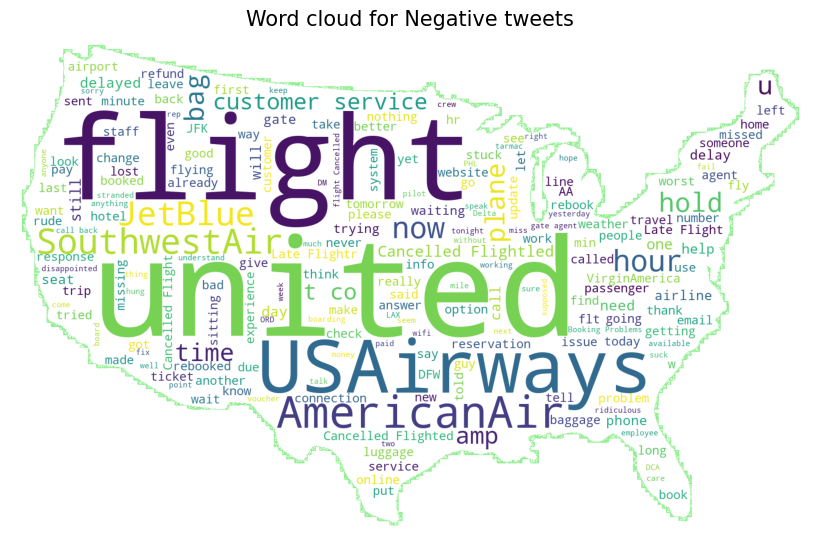

In [10]:
# Wordcloud for tweets
wordcloud(positive_df, 'text', 'Positive tweets')
wordcloud(neutral_df,  'text', 'Neutral tweets')
wordcloud(negative_df, 'text', 'Negative tweets')

Interpretation of word clouds for tweets:

The word cloud for positive tweets shows that the most frequently occuring n-grams are 'thank' and 'Jet Blue'. The word cloud for neutral tweets shows that the most frequently occuring n-grams are 'united', 'Jet Blue' and 'flight'. In both of these word clouds 'Southwestair' are frequently occuring. The word cloud for negative tweets shows that 'flight', 'united' and 'USAirways' are most frequently occuring followed by 'AmericanAir'. It is to be expected that the unigram 'flight' would frequently occur and could be treated as a stop word.

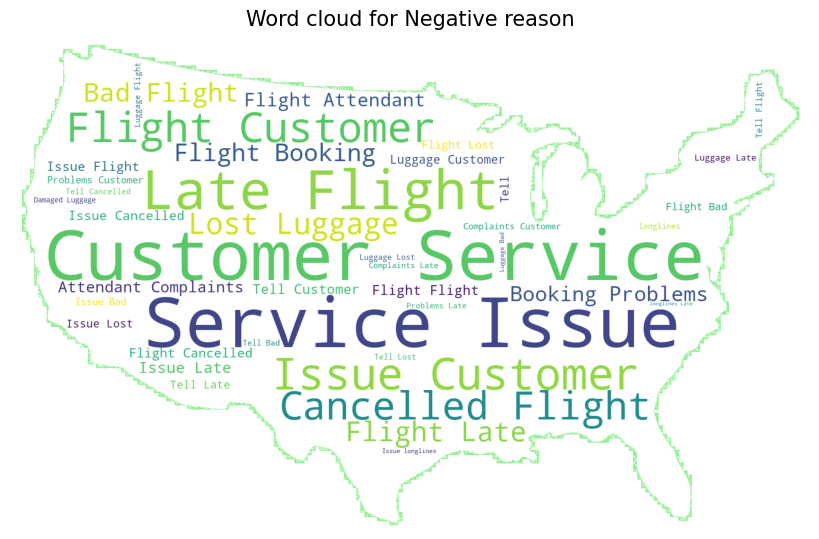

In [11]:
# Wordcloud for negative reason
wordcloud(negative_df, 'negativereason', 'Negative reason')

Interpretation of word cloud for negative reason: 

The bi-grams 'Customer Service' and 'Service Issue' present in the word cloud indicate that these are the most frequently occuring reasons for negative tweets.

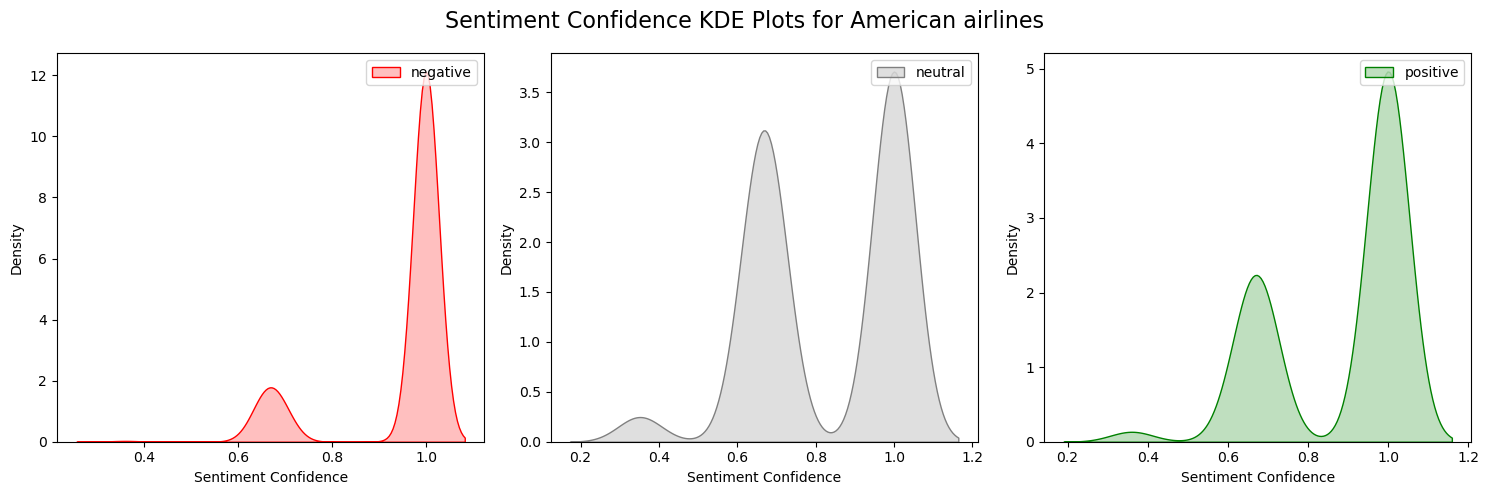

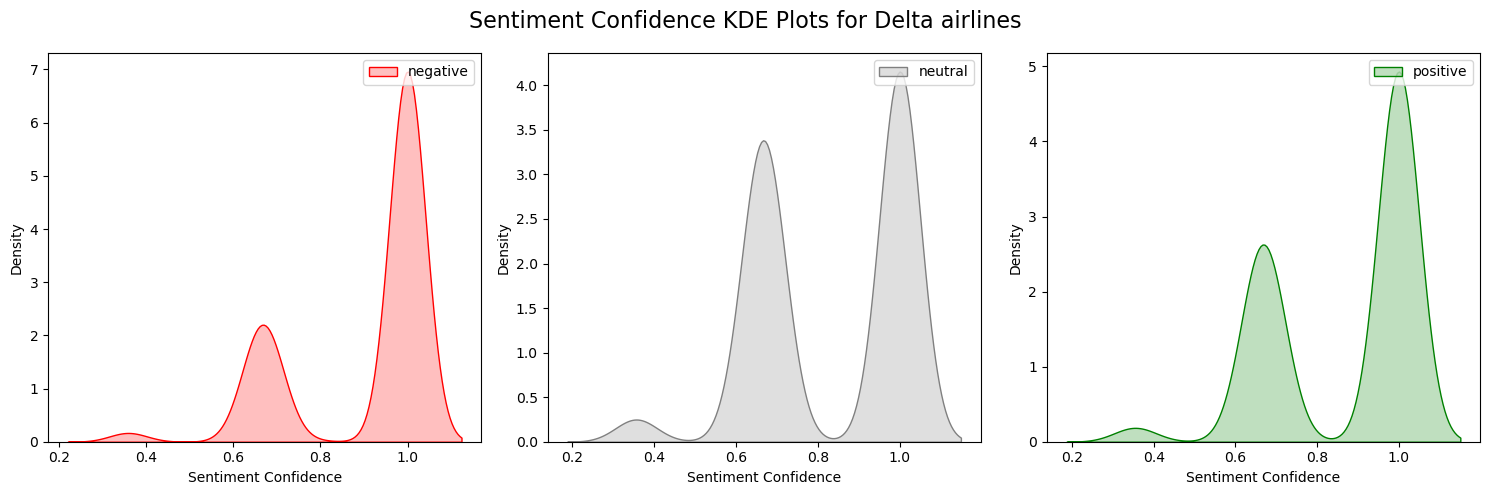

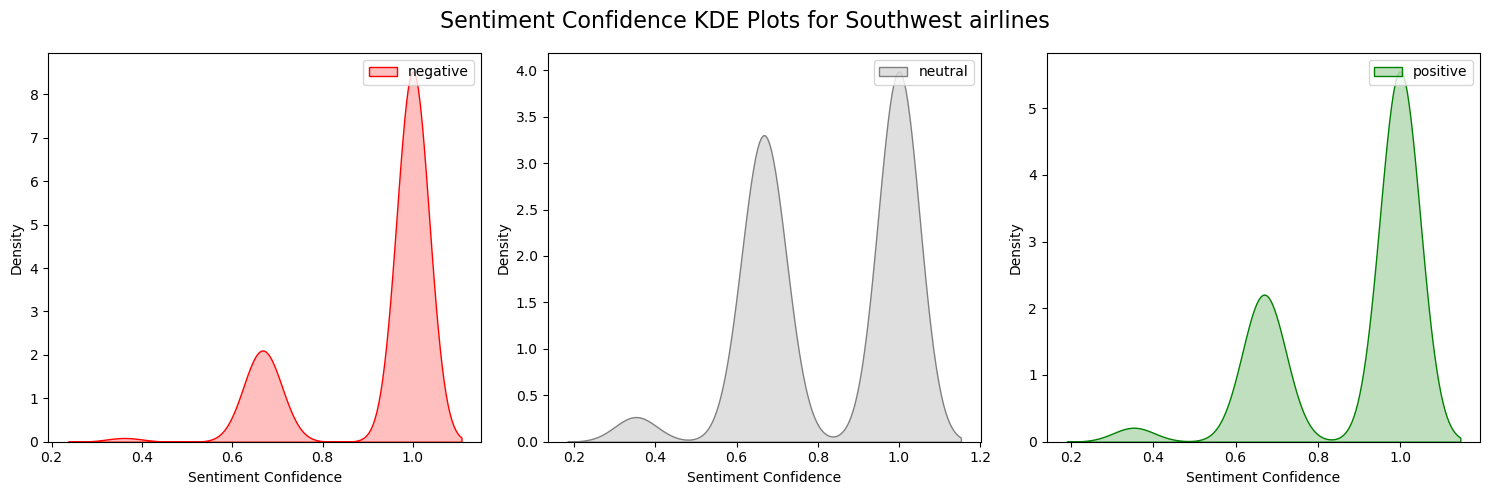

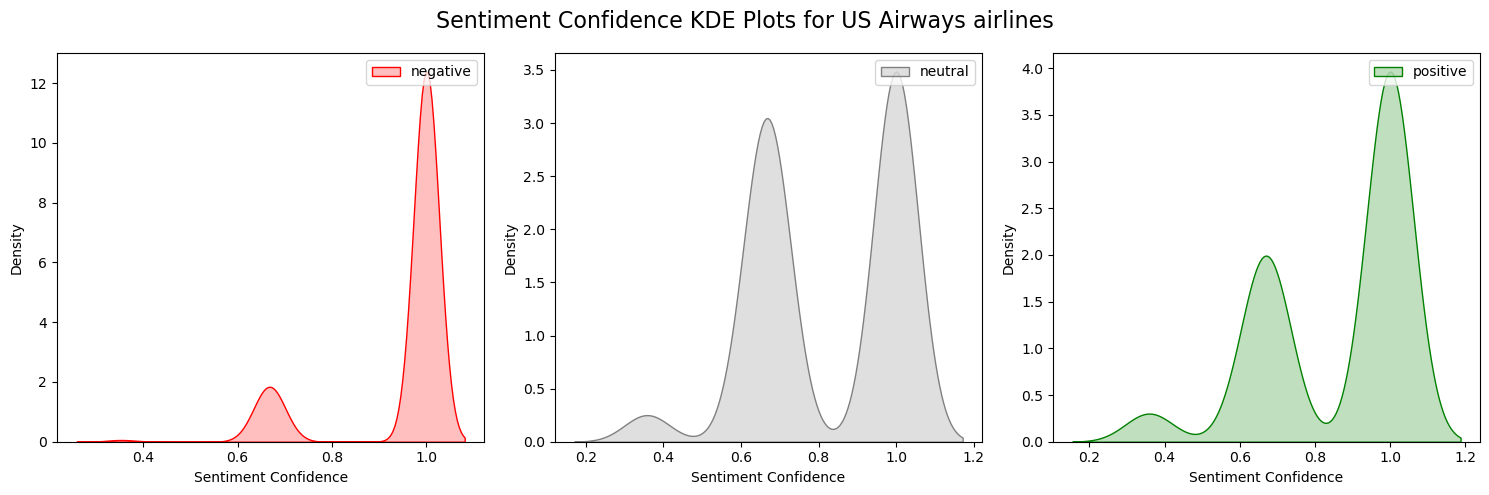

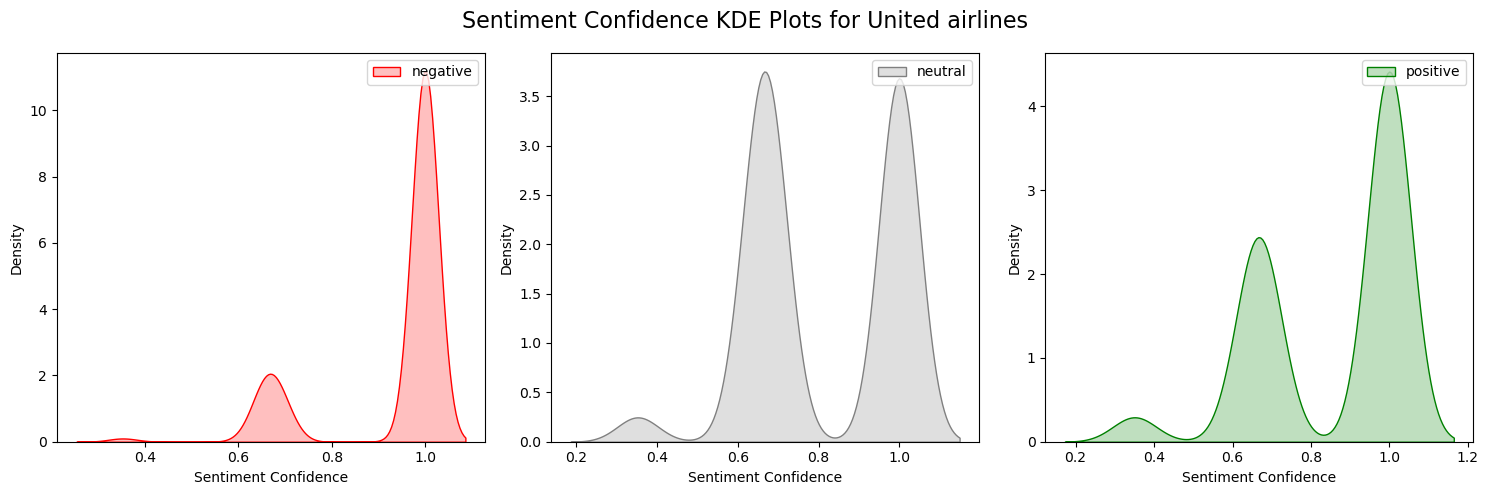

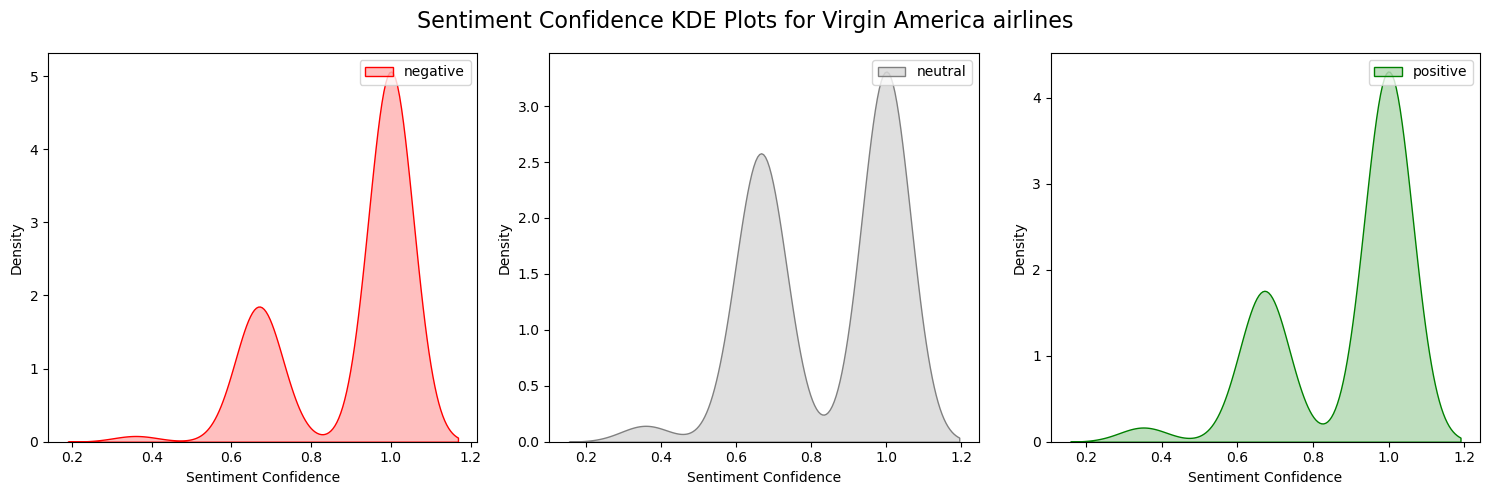

In [12]:
# Create KDE plot for airline_sentiment_confidence

def kde_plot1(df, colour):
    
    # Group the data by 'Airline_name' 
    grouped_data = df.groupby('airline')
    
    # Create subplots for each sentiment per airline
    for airline, group in grouped_data:
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))
        fig.suptitle(f"Sentiment Confidence KDE Plots for {airline} airlines", fontsize=16)
        
        for i, (sentiment, sentiment_group) in enumerate(group.groupby('airline_sentiment')):
            sns.kdeplot(data=sentiment_group['airline_sentiment_confidence'], color=colour[i], fill=True, common_norm=False, ax=axes[i], label=sentiment)
            axes[i].set_xlabel('Sentiment Confidence')
            axes[i].set_ylabel('Density')
            axes[i].legend()
        
        plt.tight_layout()
        plt.show()


# Call function
kde_plot1(df, ['red', 'grey', 'green'])

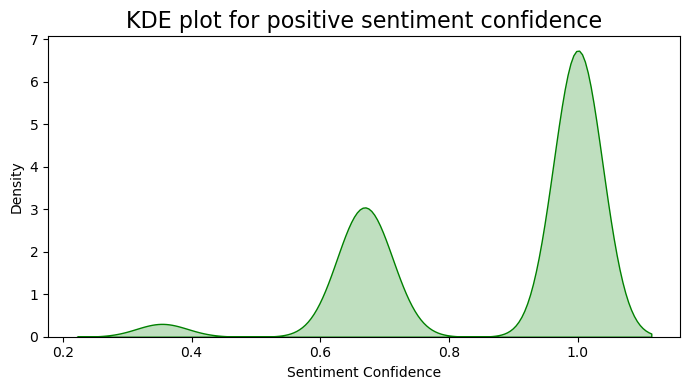

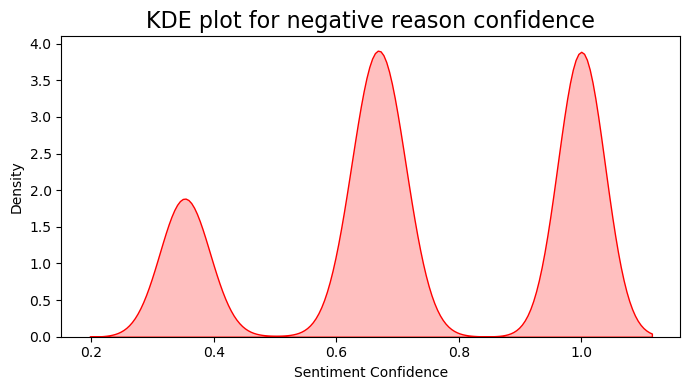

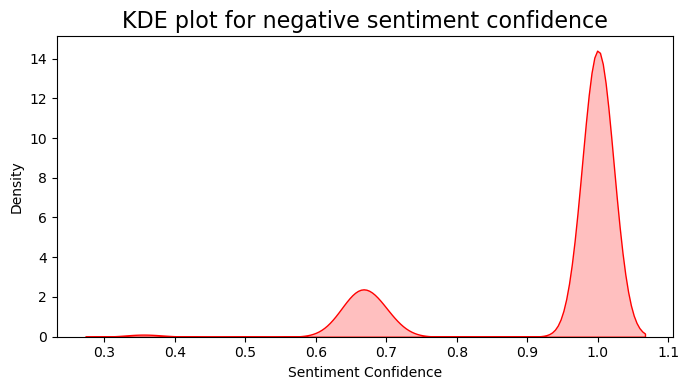

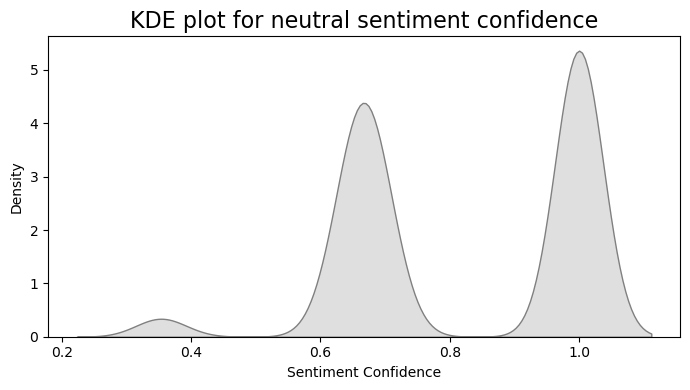

In [119]:
def kde_plot2(df, confidence, title, colour):
    
    # Create plots for sentiment confidence
    plt.figure(figsize=(7, 4))
    plt.title(f'KDE plot for {title}', fontsize=16)
    
    # Plot KDE for sentiment_confidence
    sns.kdeplot(data=df[confidence], fill=True, common_norm=False, color = colour)
    
    plt.xlabel('Sentiment Confidence')
    plt.ylabel('Density')
    
    plt.tight_layout()
    plt.show()


# Call function
kde_plot2(positive_df, 'airline_sentiment_confidence', 'positive sentiment confidence', 'green')
kde_plot2(negative_df, 'negativereason_confidence', 'negative reason confidence', 'red')
kde_plot2(negative_df, 'airline_sentiment_confidence', 'negative sentiment confidence', 'red')
kde_plot2(neutral_df, 'airline_sentiment_confidence', 'neutral sentiment confidence', 'grey')


Interpretation of KDE plots:



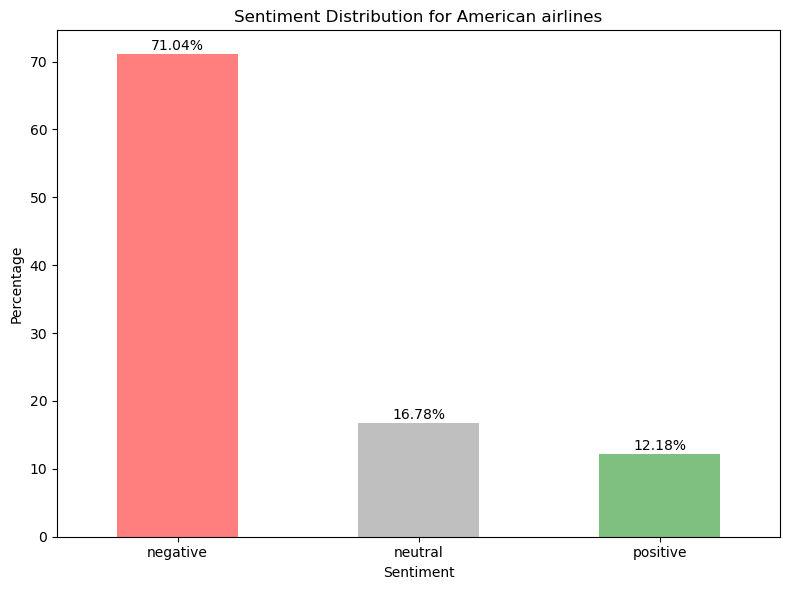

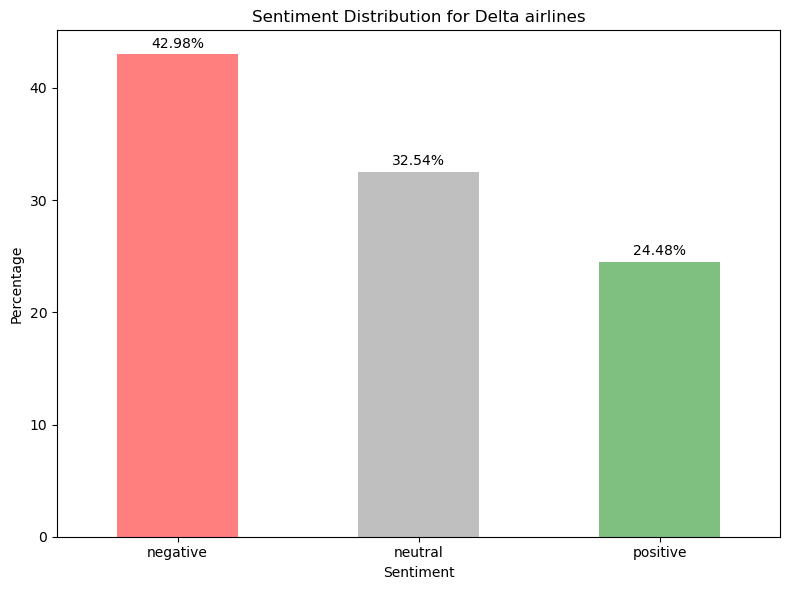

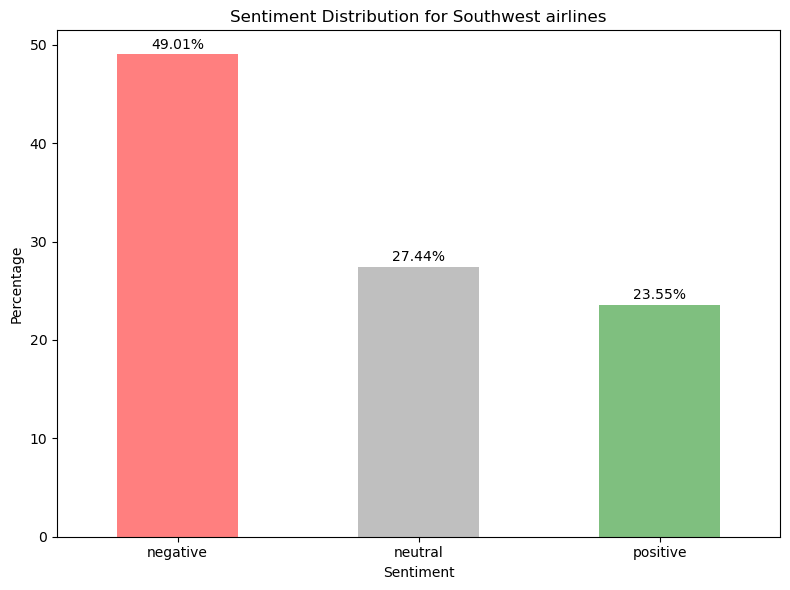

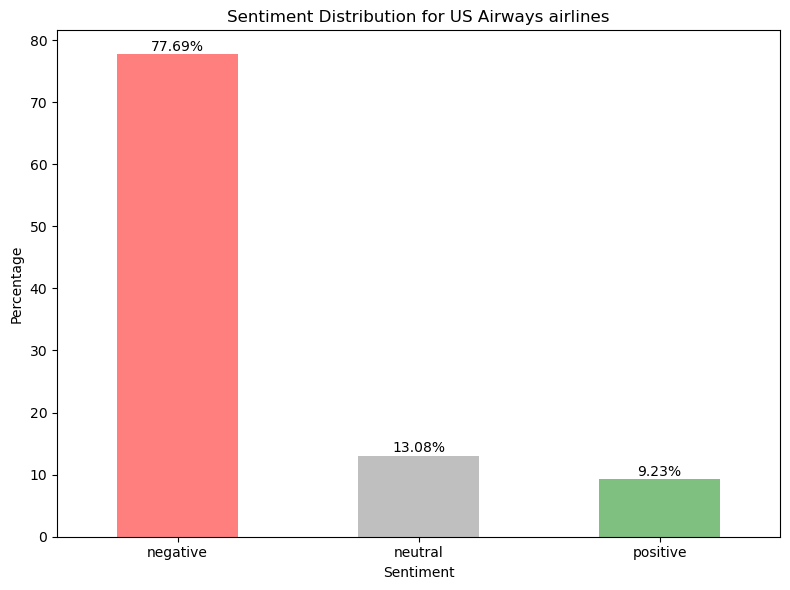

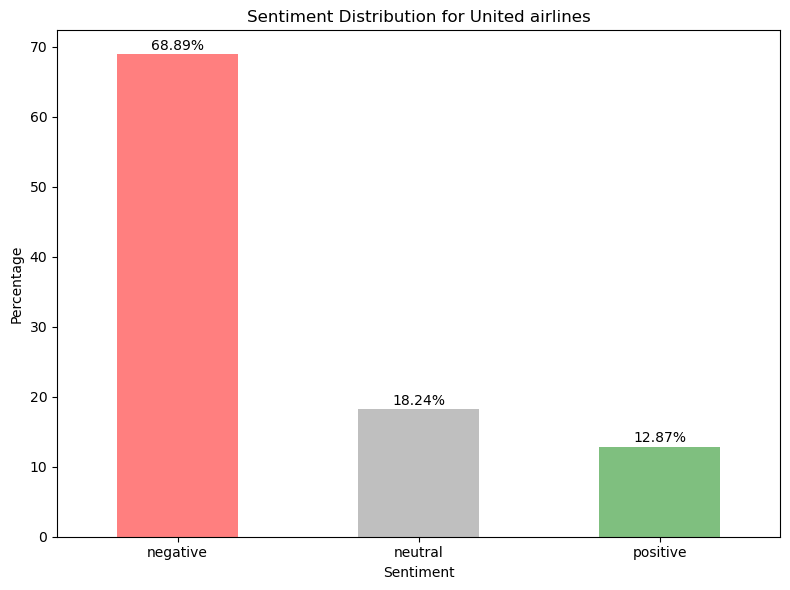

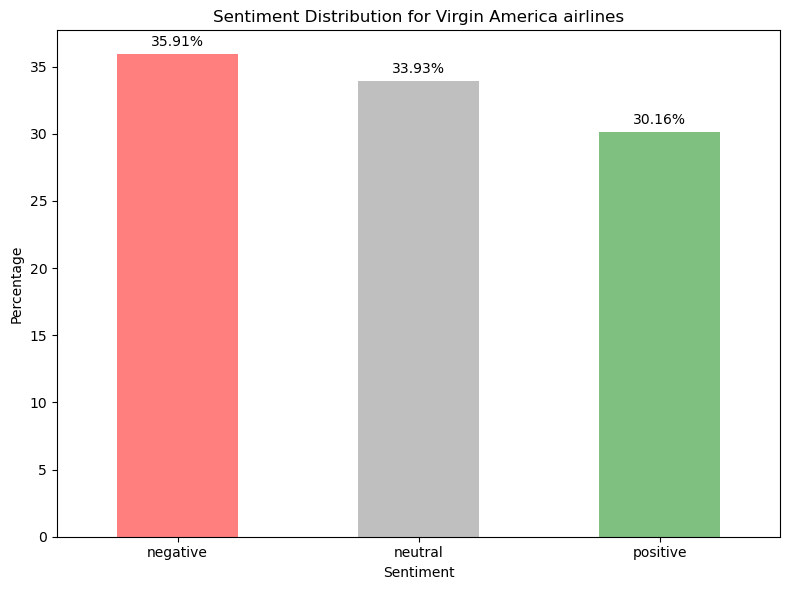

In [116]:
# Bar charts 

def bar_chart(df):
    
    # Group the data by 'Airline_name' and 'Sentiment'
    grouped_data = df.groupby('airline')

    
    # Create subplots for each airline
    for airline_name, group in grouped_data:
        # Calculate sentiment count
        sentiment_count = group['airline_sentiment'].value_counts(normalize=True) * 100
        
        # Plot the bar chart
        plt.figure(figsize=(8, 6))
        sentiment_count.plot(kind='bar', color=['red', 'grey', 'green'], alpha=0.5)
        
        
        # Set title and labels
        plt.title(f"Sentiment Distribution for {airline_name} airlines")
        plt.xlabel('Sentiment')
        plt.ylabel('Percentage')
        plt.xticks(rotation=0)
        
        # Show percentages on top of bars
        for i, value in enumerate(sentiment_count):
            plt.text(i, value + 0.6, f'{value:.2f}%', ha='center')
        
        plt.tight_layout()
        plt.show()


# Call function
bar_chart(df)

Interpretation of bar charts:

A large percentage of the tweets are negative across all airlines except for Virgin America airlines which are roughly balanced across sentiment.

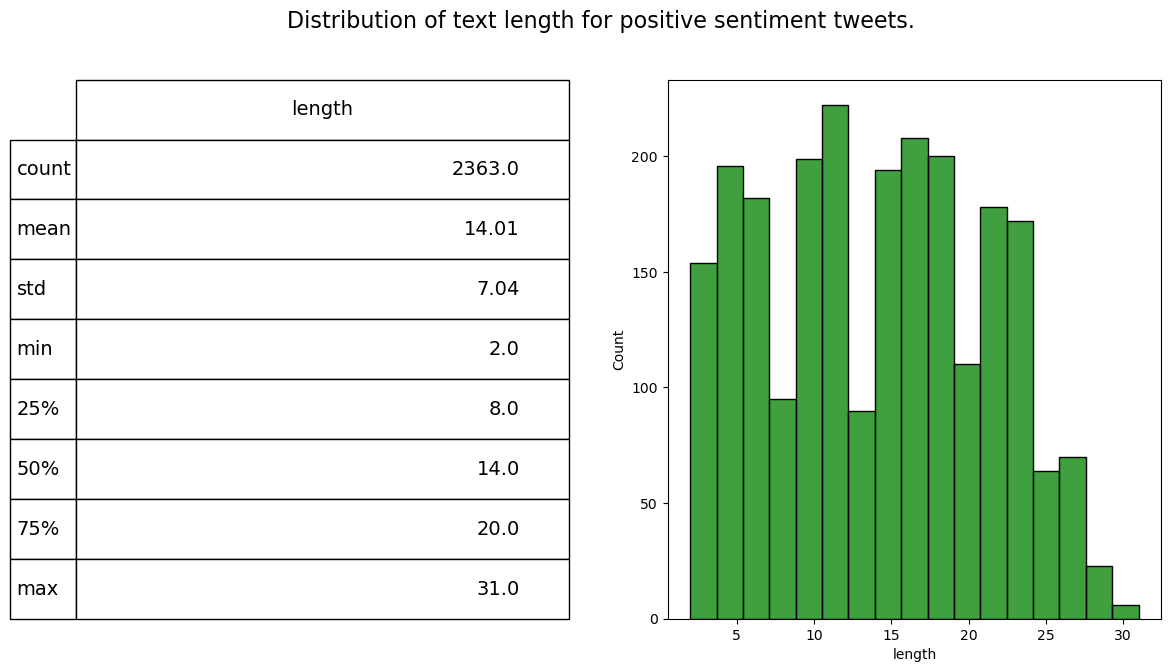

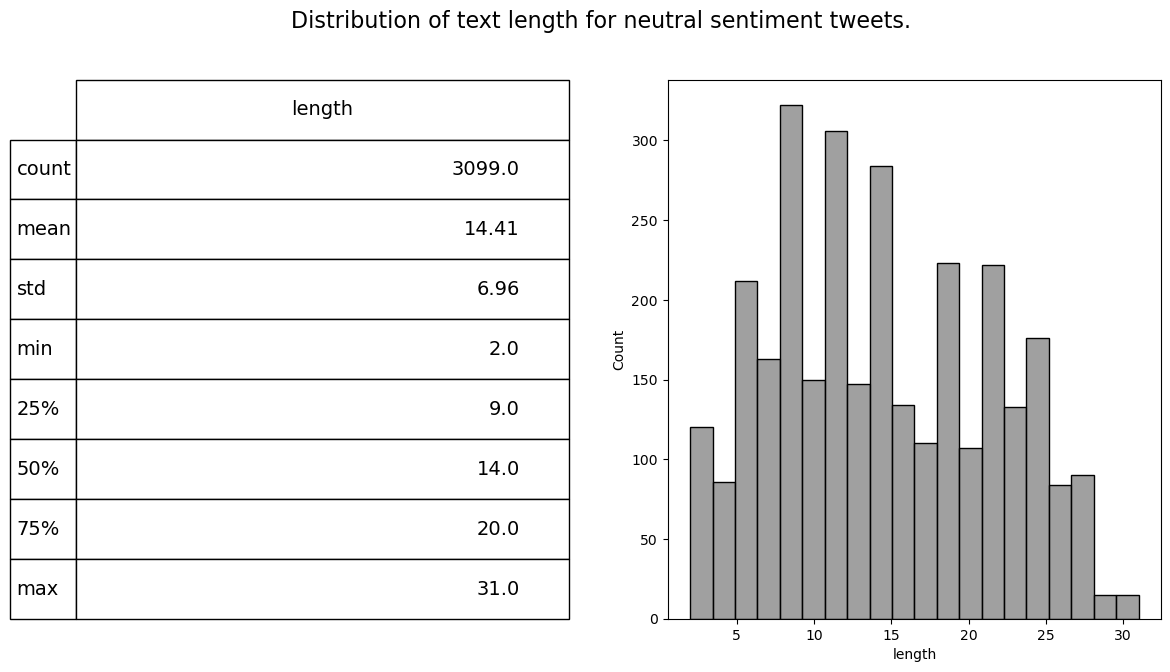

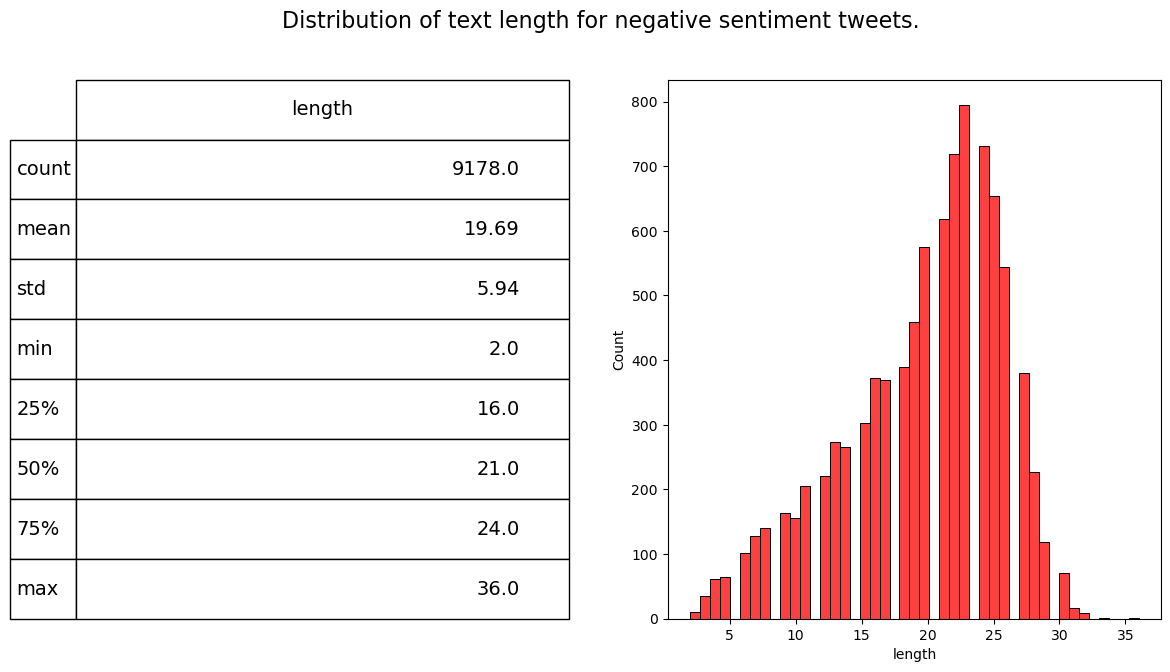

In [35]:
# Distribution of text length by sentiment category

def text_length(df, sentiment, colour):
    fig = plt.figure(figsize=(14,7))
    df['length'] = df.text.str.split().apply(len) # create length variable
    ax1 = fig.add_subplot(122)
    sns.histplot(df[df['airline_sentiment']== sentiment]['length'], ax=ax1,color=colour)
    describe = df.length[df.airline_sentiment== sentiment].describe().to_frame().round(2)
    
    ax2 = fig.add_subplot(121)
    ax2.axis('off')
    font_size = 14
    bbox = [0, 0, 1, 1]
    table = ax2.table(cellText = describe.values, rowLabels = describe.index, bbox=bbox, colLabels=describe.columns)
    table.set_fontsize(font_size)
    fig.suptitle(f'Distribution of text length for {sentiment} sentiment tweets.', fontsize=16)
    
    plt.show()


# Call function
text_length(df, 'positive', 'green')
text_length(df, 'neutral', 'grey')
text_length(df, 'negative', 'red')


Interpretations of tweet lengths:

The mean length of positive and neutral tweets is 14 tokens, whereas the mean length of negative tweets is approximately 20 tokens. Negative tweets appear to be longer than positive and neutral tweets.

code source: https://www.kaggle.com/code/kritanjalijain/twitter-sentiment-analysis-lstm

In [79]:
# Count number of tweets per airline
tweets_per_airline = df.groupby('airline').size().reset_index(name='text')

# Sort in descending order based on the count of tweets
tweets_per_airline = tweets_per_airline.sort_values(by='text', ascending=False)

print(tweets_per_airline)

          airline  text
4          United  3822
3      US Airways  2913
0        American  2759
2       Southwest  2420
1           Delta  2222
5  Virgin America   504


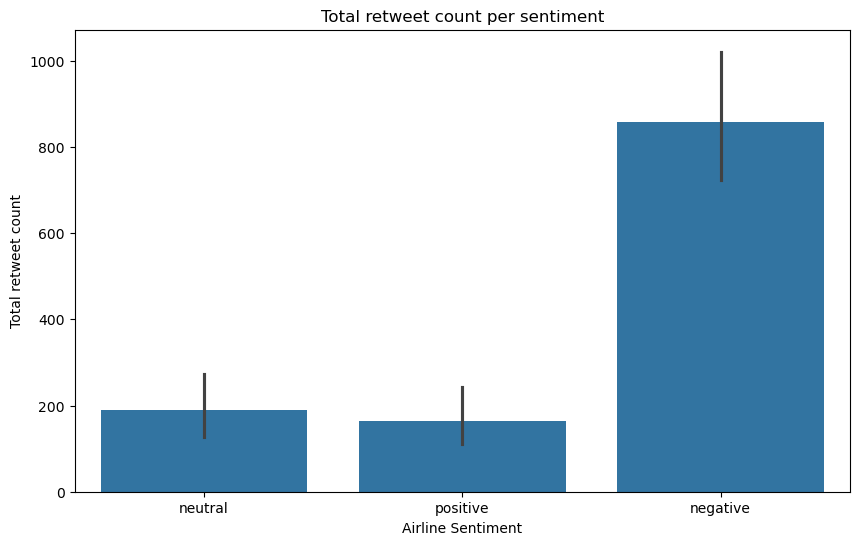

In [100]:
# Create a bar plot of the retweet_count per airline_sentiment

plt.figure(figsize=(10, 6))
sns.barplot(x='airline_sentiment', y='retweet_count', data=df, estimator=sum) # use sum as estimator
plt.title('Total retweet count per sentiment')
plt.xlabel('Airline Sentiment')
plt.ylabel('Total retweet count')
plt.show()


Interpretation of bar plot:

It can be seen that negative tweets have a greater total of retweet counts compared to neutral and positive tweets.

In [131]:
# Pie chart of tweets per sentiment

fig = px.pie(df, names='airline_sentiment', title ='Pie chart of different sentiments of tweets')
fig.show()

source code: https://www.kaggle.com/code/kritanjalijain/twitter-sentiment-analysis-lstm

# Data preprocessing

Reduce the 
number of words fed to the classifier

In [63]:
# Initialise the WordNetLemmatiser
lemmatiser = WordNetLemmatizer()

# Function to remove stopwords and lemmatise tokens
def preprocess_text(text):

    # tokenise text
    tokens = word_tokenize(text)
    
    # remove stopwords and convert to lowercase 
    stop_words = set(stopwords.words('english')) 
    filtered_tokens = [word.lower() for word in tokens if word.lower() not in stop_words and word.isalpha()] 
    lemmatised_tokens = [lemmatiser.lemmatize(token) for token in filtered_tokens]
    
    return lemmatised_tokens


# Apply function
df['text_processed'] = df['text'].apply(lambda x: preprocess_text(x))


In [64]:
print(df['text'][7]) # text before preprocessing

@VirginAmerica Really missed a prime opportunity for Men Without Hats parody, there. https://t.co/mWpG7grEZP


In [65]:
print(df['text_processed'][7]) # text after preprocessing

['virginamerica', 'really', 'missed', 'prime', 'opportunity', 'men', 'without', 'hat', 'parody', 'http']


In [66]:
df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone,sentiment,length,text_processed
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52-08:00,NaN,Eastern Time (US & Canada),0,4,"[virginamerica, dhepburn, said]"
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59-08:00,NaN,Pacific Time (US & Canada),1,9,"[virginamerica, plus, added, commercial, exper..."
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48-08:00,Lets Play,Central Time (US & Canada),0,12,"[virginamerica, today, must, mean, need, take,..."
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36-08:00,NaN,Pacific Time (US & Canada),2,17,"[virginamerica, really, aggressive, blast, obn..."
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45-08:00,NaN,Pacific Time (US & Canada),2,10,"[virginamerica, really, big, bad, thing]"


# Modelling
predict whether a tweet is positive, negative or neutral based on the retweet count, length and time tweet was created.
- predict sentiment
- stratify on airline